In [9]:
import pandas as pd

ad_df = pd.read_csv("Data/ad_click_dataset.csv")
ad_df = ad_df.sample(frac=1, random_state=42)
ad_df.head(3)

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
6252,5110,User5110,44.0,Female,NaN,Top,Shopping,NaN,1
4684,4086,User4086,NaN,Female,Desktop,Top,Entertainment,Morning,1
1731,6651,User6651,57.0,NaN,NaN,NaN,NaN,Afternoon,0


In [10]:
from sklearn.model_selection import train_test_split

X = ad_df.drop(["id", "full_name", "click"], axis=1)
y = ad_df["click"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = ["gender", "device_type", "ad_position", "browsing_history", "time_of_day"]
num_col = ["age"]

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

transform = ColumnTransformer([
    ("cat", cat_transformer, cat_col),
    ("num", num_transformer, num_col)
])

pipe = Pipeline([
    ("preprocessing", transform),
    ("model", RandomForestClassifier(n_estimators=100, random_state=125)),
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'device_type',
                                                   'ad_position',
                                                   'browsing_history',
                                                   'time_of_day']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('model', RandomForestClassifier(random_state=125))])

In [12]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

Accuracy: 72.0% F1: 0.65


In [13]:
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}")

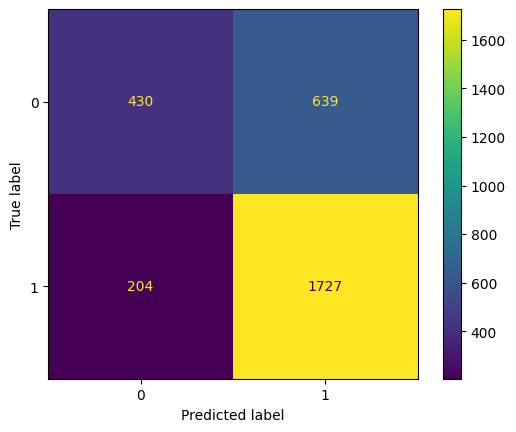

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

In [15]:
import skops.io as sio

sio.dump(pipe, "Model/ad_click_pipeline.skops")

In [16]:
import skops.io as sio

pipe_loaded = sio.load("Model/ad_click_pipeline.skops",    trusted=['numpy.dtype', 'sklearn.compose._column_transformer._RemainderColsList'])